In [1]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('fivethirtyeight')

# Modelado
# ==============================================================================
from sklearn.datasets import make_blobs
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
import multiprocessing

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

## Datos
Se simulan datos en dos dimensiones pertenecientes a tres grupos cuya separación no es perfecta

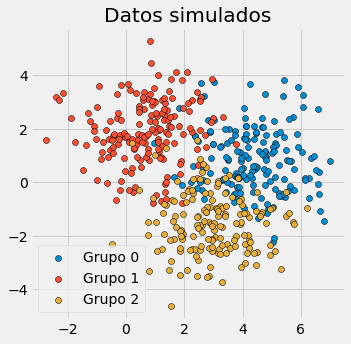

In [14]:
# Datos simulados
# ==============================================================================
X, y = make_blobs(
        n_samples    = 500, 
        n_features   = 2, 
        centers      = 3, 
        cluster_std  = 1.2, 
        shuffle      = True, 
        random_state = 0
       )

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
for i in np.unique(y):
    ax.scatter(
        x = X[y == i, 1],
        y = X[y == i, 0], 
        c = plt.rcParams['axes.prop_cycle'].by_key()['color'][i],
        marker    = 'o',
        edgecolor = 'black', 
        label= f"Grupo {i}"
    )
    
ax.set_title('Datos simulados')
ax.legend();

## Arquitectura de la red

Se procede a crear 4 modelos en orden creciente de complejidad (número de neuronas y capas), para comprobar cómo la arquitectura de la red afecta a su capacidad de aprendizaje.


In [23]:
# Modelos
# ==============================================================================
modelo_1 = MLPClassifier(
                hidden_layer_sizes=(5),
                learning_rate_init=0.01,
                solver = 'lbfgs',
                max_iter = 1000,
                random_state = 123
            )

modelo_2 = MLPClassifier(
                hidden_layer_sizes=(10),
                learning_rate_init=0.01,
                solver = 'lbfgs',
                max_iter = 1000,
                random_state = 123
            )

modelo_3 = MLPClassifier(
                hidden_layer_sizes=(50, 50),
                learning_rate_init=0.01,
                solver = 'lbfgs',
                max_iter = 5000,
                random_state = 123
            )

modelo_4 = MLPClassifier(
                hidden_layer_sizes=(100, 100, 100),
                learning_rate_init=0.01,
                solver = 'lbfgs',
                max_iter = 5000,
                random_state = 123
            )

modelo_1.fit(X=X, y=y)
modelo_2.fit(X=X, y=y)
modelo_3.fit(X=X, y=y)
modelo_4.fit(X=X, y=y)

MLPClassifier(hidden_layer_sizes=(100, 100, 100), learning_rate_init=0.01,
              max_iter=5000, random_state=123, solver='lbfgs')

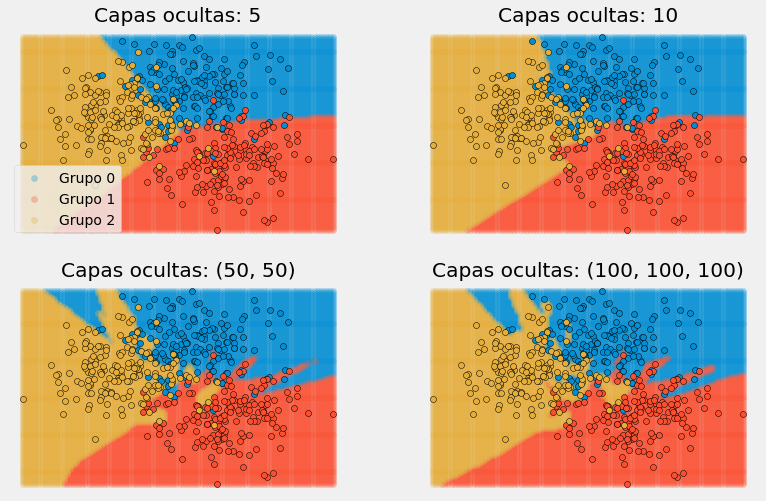

In [26]:
# Gráfico de predicciones
# ==============================================================================
fig, axs = plt.subplots(2, 2, figsize=(12,8))
axs = axs.flatten()
grid_x1 = np.linspace(start=min(X[:, 0]), stop=max(X[:, 0]), num=100)
grid_x2 = np.linspace(start=min(X[:, 1]), stop=max(X[:, 1]), num=100)
xx, yy = np.meshgrid(grid_x1, grid_x2)
X_grid = np.column_stack([xx.flatten(), yy.flatten()])

for i, modelo in enumerate([modelo_1, modelo_2, modelo_3, modelo_4]):
    
    predicciones = modelo.predict(X_grid)
    
    for j in np.unique(predicciones):
        axs[i].scatter(
            x = X_grid[predicciones == j, 0],
            y = X_grid[predicciones == j, 1], 
            c = plt.rcParams['axes.prop_cycle'].by_key()['color'][j],
            #marker = 'o',
            alpha = 0.3,
            label= f"Grupo {j}"
        )

    for j in np.unique(y):
        axs[i].scatter(
            x = X[y == j, 0],
            y = X[y == j, 1], 
            c = plt.rcParams['axes.prop_cycle'].by_key()['color'][j],
            marker    = 'o',
            edgecolor = 'black'
        )
        
    axs[i].set_title(f"Capas ocultas: {modelo.hidden_layer_sizes}")
    axs[i].axis('off')
axs[0].legend();



## Optimización de hiperparámetros

En este apartado, se muestra cómo afectan al aprendizaje algunos de los hiperparámetros más influyentes. Como los 2 predictores tienen la misma escala, no es estrictamente necesarios aplicarles una normalización previo entrenamiento.

In [28]:
# Número de neuronas
# ==============================================================================
param_grid = {'hidden_layer_sizes':[1, 5, 10, 15, 25, 50]}

grid = GridSearchCV(
        estimator = MLPClassifier(
                        learning_rate_init=0.01,
                        solver = 'lbfgs',
                        alpha  = 0,
                        max_iter = 5000,
                        random_state = 123
                    ),
        param_grid = param_grid,
        scoring    = 'accuracy',
        cv         = 5,
        refit      = True,
        return_train_score = True
      )

_ = grid.fit(X, y)


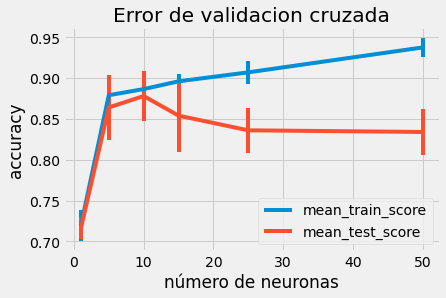

In [29]:
fig, ax = plt.subplots(figsize=(6, 3.84))
scores = pd.DataFrame(grid.cv_results_)
scores.plot(x='param_hidden_layer_sizes', y='mean_train_score', yerr='std_train_score', ax=ax)
scores.plot(x='param_hidden_layer_sizes', y='mean_test_score', yerr='std_test_score', ax=ax)
ax.set_ylabel('accuracy')
ax.set_xlabel('número de neuronas')
ax.set_title('Error de validacion cruzada');

In [30]:
# learning rate
# ==============================================================================
param_grid = {'learning_rate_init':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100]}

grid = GridSearchCV(
        estimator = MLPClassifier(
                        hidden_layer_sizes=(10),
                        solver = 'adam',
                        alpha  = 0,
                        max_iter = 5000,
                        random_state = 123
                    ),
        param_grid = param_grid,
        scoring    = 'accuracy',
        cv         = 5,
        refit      = True,
        return_train_score = True
      )

_ = grid.fit(X, y)

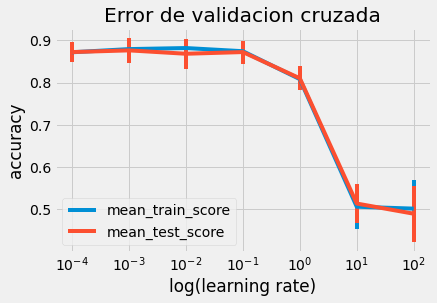

In [31]:
fig, ax = plt.subplots(figsize=(6, 3.84))
scores = pd.DataFrame(grid.cv_results_)
scores.plot(x='param_learning_rate_init', y='mean_train_score', yerr='std_train_score', ax=ax)
scores.plot(x='param_learning_rate_init', y='mean_test_score', yerr='std_test_score', ax=ax)
ax.set_xscale('log')
ax.set_xlabel('log(learning rate)')
ax.set_ylabel('accuracy')
ax.set_title('Error de validacion cruzada');

In [35]:
# Espacio de búsqueda de cada hiperparámetro
# ==============================================================================
param_distributions = {
    'hidden_layer_sizes': [(10), (10, 10), (20, 20)],
    'alpha': np.logspace(-3, 3, 7),
    'learning_rate_init': [0.001, 0.01, 0.1],
}

# Búsqueda por validación cruzada
# ==============================================================================
grid = RandomizedSearchCV(
        estimator  = MLPClassifier(solver = 'lbfgs', max_iter= 2000),
        param_distributions = param_distributions,
        n_iter     = 5, # Número máximo de combinaciones probadas
        scoring    = 'accuracy',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = 3, 
        verbose    = 0,
        random_state = 123,
        return_train_score = True
       )

grid.fit(X = X, y = y)

# Resultados del grid
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False)\
    .head(10)

/home/miguel/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


,param_learning_rate_init,param_hidden_layer_sizes,param_alpha,mean_test_score,std_test_score,mean_train_score,std_train_score
1,0.001,"(10, 10)",10.0,0.863923,0.035070,0.879982,0.021462
4,0.01,"(20, 20)",10.0,0.863923,0.035070,0.879979,0.021889
3,0.01,"(10, 10)",1.0,0.861891,0.053278,0.898965,0.029536
2,0.001,"(20, 20)",0.01,0.835979,0.018704,0.929984,0.011401
0,0.001,"(20, 20)",0.1,0.818003,0.026906,0.936002,0.005079


In [36]:
modelo = grid.best_estimator_
modelo

MLPClassifier(alpha=10.0, hidden_layer_sizes=(10, 10), max_iter=2000,
              solver='lbfgs')

In [37]:
grid_x1 = np.linspace(start=min(X[:, 0]), stop=max(X[:, 0]), num=100)
grid_x2 = np.linspace(start=min(X[:, 1]), stop=max(X[:, 1]), num=100)
xx, yy = np.meshgrid(grid_x1, grid_x2)

X_grid = np.column_stack([xx.flatten(), yy.flatten()])
predicciones = modelo.predict(X_grid)


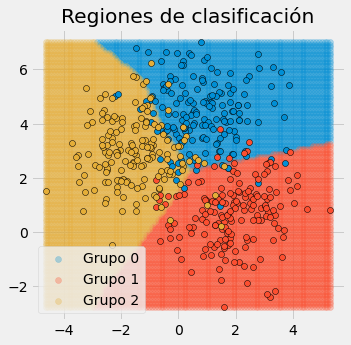

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

for i in np.unique(predicciones):
    ax.scatter(
        x = X_grid[predicciones == i, 0],
        y = X_grid[predicciones == i, 1], 
        c = plt.rcParams['axes.prop_cycle'].by_key()['color'][i],
        #marker = 'o',
        alpha = 0.3,
        label= f"Grupo {i}"
    )

for i in np.unique(y):
    ax.scatter(
        x = X[y == i, 0],
        y = X[y == i, 1], 
        c = plt.rcParams['axes.prop_cycle'].by_key()['color'][i],
        marker    = 'o',
        edgecolor = 'black'
    )
    

ax.set_title('Regiones de clasificación')
ax.legend();
